<a href="https://colab.research.google.com/github/FariaParvinMegha/deep_dive_NN/blob/main/makemore_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open('/content/drive/MyDrive/NN_zero_to_hero/required_files/names.txt', 'r').read().splitlines()
words[:12]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily']

In [ ]:
print(len(words))
print(max(len(w) for w in words))
print(min(len(w) for w in words))

32033
15
2


In [ ]:
N  = torch.zeros((27,27), dtype = torch.int32)

In [ ]:
chars = sorted(list(set(''.join(words))))               #sorted list of the characters in the dataset. set threw out the duplicated. so basically list of a-z
s_to_i = {s:i+1 for i,s in enumerate(chars)}            # enumerate returns the integer index of a certain component of a list
s_to_i ['.'] = 0
i_to_s = {i:s for s,i in s_to_i.items()}

In [ ]:
xs, ys = [], []
for w in words:                                                               #creating trigrams count
  chs = ['.'] +list(w) + ['.']
  for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
    ix1 = s_to_i[ch1]
    ix2 = s_to_i[ch2]
    ix3 = s_to_i[ch3]
    # print (ch1, ch2, ch3)
    i_pair = [ix1, ix2]
    xs.append(i_pair)
    ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = torch.tensor(xs.nelement()//2)
print('number of trigrams: ', num)
print(xs.shape)

number of trigrams:  tensor(196113)
torch.Size([196113, 2])


# Creating NN

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F

In [ ]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)


In [ ]:
# gradient descent
loss_history = [] # Initialize a list to store loss values
for k in range(30):

  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ..., ys].log().mean() + 0.01*(W**2).mean()       #softmax is used      #nll and regularization
  print(loss.item())
  loss_history.append(loss.item()) # Store the loss value

  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()

  # update
  W.data += -50 * W.grad

0.9116867780685425
0.8553094267845154
0.8259212970733643
0.8067570924758911
0.7926292419433594
0.781731128692627
0.7730140089988708
0.7658448219299316
0.7598259449005127
0.7546926140785217
0.7502591013908386
0.7463898658752441
0.7429832220077515
0.7399614453315735
0.7372636198997498
0.7348417639732361
0.7326569557189941
0.7306776642799377
0.7288777828216553
0.7272351980209351
0.7257315516471863
0.7243508696556091
0.7230794429779053
0.721905529499054
0.720818817615509
0.719810426235199
0.7188723087310791
0.7179978489875793
0.7171807289123535
0.7164156436920166


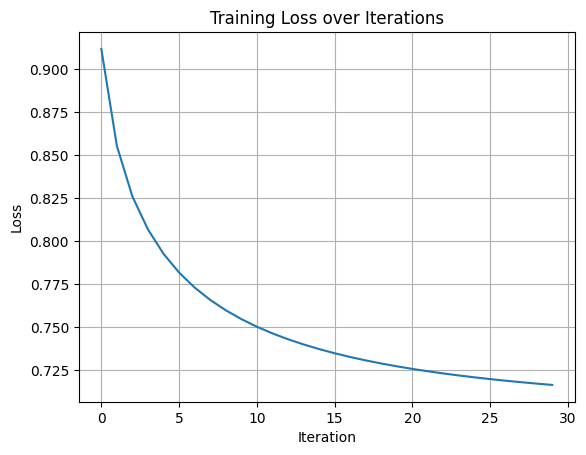

In [ ]:
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over Iterations")
plt.grid(True)
plt.show()

Trigram model showed huge improvement over bigram model. for a non-biased comparison i have kept the seed same as the bigram model.

# dividing the dataset into training, validation and testing set

In [ ]:
dataset = TensorDataset(xs, ys)

In [ ]:
num_items = len(dataset)
train_items = int(0.8 * num_items)
val_items = int(0.1 * num_items)
test_items = num_items - train_items - val_items

In [ ]:
g = torch.Generator().manual_seed(2147483647)

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_items, val_items, test_items], generator=g)


In [34]:
train_data = torch.stack([item[0] for item in train_dataset])
train_label = torch.stack([item[1] for item in train_dataset])          # could've used train_data = train_dataset[:][0] train_labels = train_dataset[:][1] syntax.
                                                                        # here [:] access the whole tensor subset and [0]&[1] helps to access and store the xs and ys respectively.
val_data = torch.stack([item[0] for item in val_dataset])               # (not efficient)
val_label = torch.stack([item[1] for item in val_dataset])

test_data = torch.stack([item[0] for item in test_dataset])               # (not efficient)
test_label = torch.stack([item[1] for item in test_dataset])


In [ ]:
# def train(reg_strength, epochs=200):
  """
  Trains a simple neural network model for character prediction.

  Args:
    reg_strength (float): The strength of the L2 regularization term.
    epochs (int, optional): The number of training epochs. Defaults to 200.

  Returns:
    tuple: A tuple containing:
      - W (torch.Tensor): The trained weight tensor.
      - final_loss (float): The final loss value after training.
  """
  # initialize the 'network'
  # W is the weight matrix. It has a shape of (54, 27) to handle
  # the concatenated one-hot encoded input of two characters (27 + 27 = 54)
  # and output probabilities for the next character (27 possible characters).
  # requires_grad=True enables gradient calculation for backpropagation.
  # W = torch.randn((54, 27), generator=g, requires_grad=True)
  # loss = 0.0 # Initialize loss variable

  # gradient descent
  # Loop for the specified number of training epochs
  # for k in range(epochs):

    # Split the weight matrix W into two parts:
    # W1 for the first input character's one-hot encoding (first 27 rows)
    # W2 for the second input character's one-hot encoding (remaining 27 rows)
    # W1 = W[:27]
    # W2 = W[27:]

    # Perform the forward pass:
    # 1. train_data[:, 0] gets the indices of the first character in each pair from the training data.
    # 2. train_data[:, 1] gets the indices of the second character in each pair from the training data.
    # 3. W1[train_data[:, 0]] selects the rows from W1 corresponding to the first characters' indices.
    # 4. W2[train_data[:, 1]] selects the rows from W2 corresponding to the second characters' indices.
    # 5. The results from W1 and W2 are added element-wise. This is equivalent to
    #    (one_hot(char1) @ W1) + (one_hot(char2) @ W2)
    #    where one_hot() is the one-hot encoding function.
    # 6. The result, logits, represents the raw scores (log-counts) for each possible next character.
    # logits = W1[train_data[:, 0]] + W2[train_data[:, 1]]

    # Calculate the loss:
    # 1. F.cross_entropy calculates the cross-entropy loss between the logits and the true labels (train_label).
    #    Cross-entropy is a common loss function for classification tasks.
    # 2. reg_strength*(W**2).mean() calculates the L2 regularization term.
    #    It penalizes large weights to prevent overfitting. The mean of the squared weights
    #    is multiplied by the regularization strength.
    # 3. The total loss is the sum of the cross-entropy loss and the regularization term.
    # loss = F.cross_entropy(logits, train_label) + reg_strength*(W**2).mean()

    # Print the loss for the current epoch
    # print(loss.item())

    # backward pass
    # Reset the gradients of W to zero before calculating new gradients.
    # This is important because gradients accumulate by default in PyTorch.
    # W.grad = None # set to zero the gradient
    # Perform backpropagation: calculates the gradients of the loss with respect to W.
    # loss.backward()

    # update
    # Update the weights using gradient descent.
    # W.data is used to modify the tensor in-place without tracking the operation for gradient calculation.
    # -50 is the learning rate, controlling the step size of the update.
    # W.grad is the calculated gradient of the loss with respect to W.
    # W.data += -50 * W.grad

  # Return the trained weight tensor and the final loss value
  # return W, loss.item()

training function

In [46]:
loss_history = []
def train(regularization, epochs=50):

  W = torch.randn((54, 27), generator=g, requires_grad=True)
  loss = 0.0

  for k in range(epochs):

    W1 = W[:27]                             #old method: building a 27dimensional vector full of zeros except on 1 in each row and multiplying the whole thing with w. (takes lots of memory)
    W2 = W[27:]                             #new method: we know which one will be the 1. so just pick that up and multiply them with w directly.
                                            # that's why we split w into w1 and w2. for each characters of the input

    logits = W1[train_data[:, 0]] + W2[train_data[:, 1]]          #here we multiplied only that specific w with the training data. and thus one-hot encoding is performed implicitly
    loss = F.cross_entropy(logits, train_label) + regularization*(W**2).mean()        #cross_entropy is used instead of softmax. better for classification type problems like this
    print(loss.item())
    loss_history.append(loss.item())

    W.grad = None # set to zero the gradient
    loss.backward()
    W.data += -50 * W.grad
  return W, loss.item()


evaluation function

In [50]:
loss_history= []
def evaluate_loss(W, xs, ys):
  W1 = W[:27]
  W2 = W[27:]

  logits = W1[xs[:, 0]] + W2[xs[:, 1]]
  loss = F.cross_entropy(logits, ys)
  loss_history.append(loss.item())

  return loss.item()

In [42]:
train_losses = []
val_losses = []
regularization = []

for i in torch.linspace(0, 0.25, 50):
  W, train_loss = train(i)
  train_losses.append(train_loss)
  val_losses.append(evaluate_loss(W, val_data, val_label))
  regularization.append(i.item())

tasted various regularization value on training and validation set to find ouot whoch works the best. 50 values are taken between 0 and 0.25 at regular interval. the losses are recorded fro each value and shown in a plot

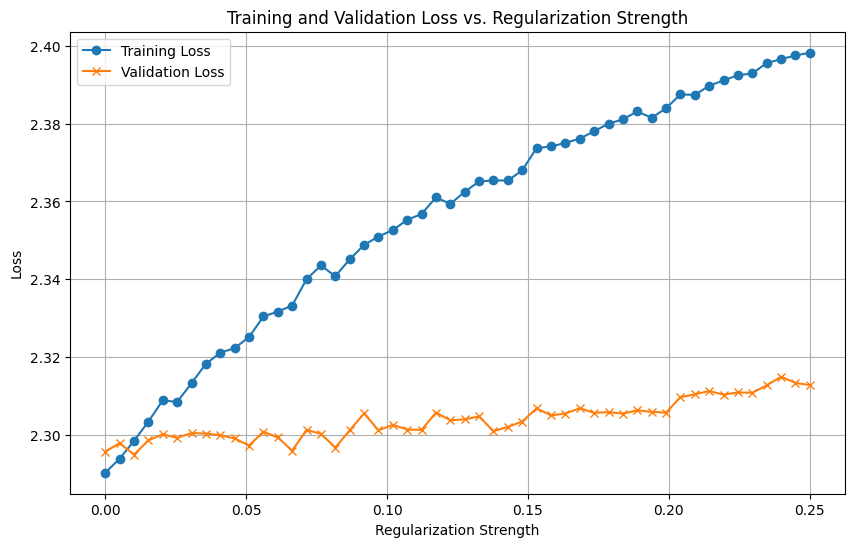

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(regularization, train_losses, label='Training Loss', marker='o')
plt.plot(regularization, val_losses, label='Validation Loss', marker='x')
plt.xlabel('Regularization Strength')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Regularization Strength')
plt.legend()
plt.grid(True)
plt.show()

from the graph it is seen that at 0.07 regularization the validation loss is minimum. so taking that. grater regularization = greater loss. causes underfitting.

In [47]:
w, train_loss = train(0.07, 50)

3.9718549251556396
3.269198417663574
2.9897048473358154
2.84183669090271
2.7482104301452637
2.6824827194213867
2.6339128017425537
2.5962798595428467
2.5661063194274902
2.54119873046875
2.5202555656433105
2.5023694038391113
2.4869325160980225
2.4734785556793213
2.461665391921997
2.4512157440185547
2.441915273666382
2.433586597442627
2.4260871410369873
2.4192984104156494
2.4131226539611816
2.4074792861938477
2.4023001194000244
2.397529363632202
2.3931188583374023
2.389028787612915
2.3852250576019287
2.3816776275634766
2.3783624172210693
2.3752567768096924
2.372342348098755
2.3696019649505615
2.367021322250366
2.36458683013916
2.3622870445251465
2.360111951828003
2.3580515384674072
2.356097936630249
2.354243278503418
2.3524796962738037
2.350802183151245
2.3492040634155273
2.3476808071136475
2.346226930618286
2.3448381423950195
2.343510150909424
2.3422398567199707
2.3410232067108154
2.3398571014404297
2.338738441467285


used the optimum w from above to finally training and testing

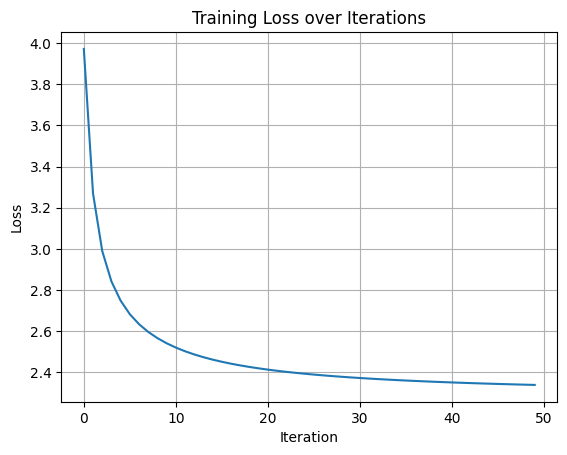

In [48]:
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over Iterations")
plt.grid(True)
plt.show()

In [51]:
evaluate_loss(W, test_data, test_label)

2.311372756958008

let's do prediction

In [52]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

  out = []
  W1 = W[:27]
  W2 = W[27:]
  x1, x2 = 0, 0
  while True:
    x1, x2 = torch.tensor([x1]), torch.tensor([x2])

    logits = W1[x1] + W2[x2]

    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------

    x1 = x2
    x2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(i_to_s[x2])
    if x2 == 0:
      break
  print(''.join(out))

dex.
amiegllurailazityh.
elllimittain.
lusan.
ka.
